In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    confusion_matrix,
    accuracy_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

In [ ]:
# Load Dataset
df = pd.read_excel("mobile_app_reviews.xlsx", sheet_name="multilingual_mobile_app_reviews")
print(df)

      review_id  user_id      app_name       app_category  \
0             1  1967825     MX Player     Travel & Local   
1             2  9242600        Tinder         Navigation   
2             3  7636477       Netflix             Dating   
3             4   209031         Venmo       Productivity   
4             5  7190293  Google Drive          Education   
...         ...      ...           ...                ...   
2509       2510  2322118      OneDrive           Business   
2510       2511  2167693        Signal            Finance   
2511       2512  5554467      OneDrive  Social Networking   
2512       2513  8805125      Coursera  Social Networking   
2513       2514  1099793         Venmo          Education   

                                            review_text review_language  \
0     Qui doloribus consequuntur. Perspiciatis tempo...              no   
1     Great app but too many ads, consider premium v...              ru   
2     The interface could be better but ov

In [ ]:
# HYPOTHESIS TESTING: CORRELATION

dependent_var = 'rating' # Define dependent_var here

# Example independent variable: 'review_length'
independent_var = 'review_length'

print("\n===== Correlation Tests ====")

# Ensure 'rating' is numeric in the main DataFrame
if "rating" in df.columns:
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
else:
    print("Warning: 'rating' column not found. Skipping correlation test.")
    # Consider what to do if 'rating' is genuinely missing
    raise KeyError("'rating' column not found in DataFrame.")

# Ensure 'review_length' exists in the main DataFrame
if independent_var not in df.columns:
    text_col = None
    for c in ["review", "review_text", "comment", "text", "content", "body", "reviewBody"]:
        if c in df.columns:
            text_col = c
            break
    if text_col is not None:
        df[independent_var] = df[text_col].astype(str).str.len()
    else:
        print(f"Warning: '{independent_var}' or a suitable text column not found. Cannot perform correlation.")
        # Early exit if a critical column is missing
        raise KeyError(f"'{independent_var}' or a suitable text column not found in DataFrame.")


# Make sure both columns are numeric and have no NaN values
# Now both 'rating' and 'review_length' should be available in df
clean_df = df[[dependent_var, independent_var]].dropna().copy()
clean_df = clean_df.apply(pd.to_numeric, errors='coerce').dropna() # Ensure numeric again after filling

if not clean_df.empty:
    # Pearson Correlation
    pearson_corr, p_pearson = stats.pearsonr(clean_df[dependent_var], clean_df[independent_var])
    print(f"Pearson correlation: {pearson_corr:.3f} | P-value: {p_pearson:.5f}")

    # Spearman Correlation
    spearman_corr, p_spearman = stats.spearmanr(clean_df[dependent_var], clean_df[independent_var])
    print(f"Spearman correlation: {spearman_corr:.3f} | P-value: {p_spearman:.5f}")
else:
    print("Not enough clean data to perform correlation analysis.")


===== Correlation Tests ====
Pearson correlation: 0.019 | P-value: 0.35216
Spearman correlation: 0.008 | P-value: 0.68595


In [ ]:
# ONE-SAMPLE T-TEST (Sample vs Population Mean)

# RANDOM SAMPLING (n = 150)
sample_random = df.sample(n=150, random_state=42)

pop_mean = df[dependent_var].mean()

# Filter out NaN values from sample_random[dependent_var] before passing to ttest_1samp
sample_data_for_ttest = sample_random[dependent_var].dropna()

# Check if there's enough data after dropping NaNs
if len(sample_data_for_ttest) > 1:
    t_stat, p_val = stats.ttest_1samp(sample_data_for_ttest, pop_mean)

    print("===== One-Sample t-Test ====")
    print(f"T-Statistic: {t_stat:.3f} | P-Value: {p_val:.5f}")

    if p_val < 0.05:
        print(" The sample is significantly different from the population mean.")
    else:
        print(" The sample represents the population (no significant difference).")
else:
    print("===== One-Sample t-Test ====")
    print("Not enough data in the sample to perform one-sample t-test after dropping NaN values.")

===== One-Sample t-Test ====
T-Statistic: -1.350 | P-Value: 0.17916
 The sample represents the population (no significant difference).


In [ ]:
# Display basic info
print("===== Dataset Information =====")
print(df.info())
print("===== First 5 Records =====")
print(df.head())

===== Dataset Information =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   review_id          2514 non-null   int64         
 1   user_id            2514 non-null   int64         
 2   app_name           2514 non-null   object        
 3   app_category       2514 non-null   object        
 4   review_text        2455 non-null   object        
 5   review_language    2514 non-null   object        
 6   rating             2477 non-null   float64       
 7   review_date        2514 non-null   datetime64[ns]
 8   verified_purchase  2514 non-null   bool          
 9   device_type        2514 non-null   object        
 10  num_helpful_votes  2514 non-null   int64         
 11  user_age           2514 non-null   int64         
 12  user_country       2473 non-null   object        
 13  user_gender        1927 non-nul

In [ ]:
# Define Descriptive Statistics Function
def descriptive_stats(data, column):
    """
    Function to calculate and print descriptive statistics for a given column in a dataset.
    """
    stats_dict = {
        'count': data[column].count(),
        'mean': data[column].mean(),
        'median': data[column].median(),
        'mode': data[column].mode()[0],
        'variance': data[column].var(),
        'std_dev': data[column].std(),
        'min': data[column].min(),
        'max': data[column].max(),
        'Q1': data[column].quantile(0.25),
        'Q3': data[column].quantile(0.75),
        'IQR': data[column].quantile(0.75) - data[column].quantile(0.25)
    }

    # Convert to Series for display and return
    stats_series = pd.Series(stats_dict)

    # Print neatly formatted descriptive statistics
    print(f"\n===== Descriptive Statistics for '{column}' =====")
    print(stats_series.to_string())
    print("===============================================")

    return stats_series



In [ ]:
 # RANDOM SAMPLING (n = 150)

sample_random = df.sample(n=150, random_state=42)

# Assuming the dependent variable is 'rating'
dependent_var = 'rating'

print("\n===== Descriptive Statistics (Random Sampling) =====")
desc_random = descriptive_stats(sample_random, dependent_var)
print(desc_random)


===== Descriptive Statistics (Random Sampling) =====

===== Descriptive Statistics for 'rating' =====
count       148.000000
mean          2.889865
median        2.800000
mode          3.300000
variance      1.397652
std_dev       1.182223
min           1.000000
max           5.000000
Q1            1.975000
Q3            4.000000
IQR           2.025000
count       148.000000
mean          2.889865
median        2.800000
mode          3.300000
variance      1.397652
std_dev       1.182223
min           1.000000
max           5.000000
Q1            1.975000
Q3            4.000000
IQR           2.025000
dtype: float64


In [ ]:
# SYSTEMATIC SAMPLING (pick every kth record)

k = len(df) // 150  # interval
sample_systematic = df.iloc[::k, :].head(150)

print("===== Descriptive Statistics (Systematic Sampling) =====")
desc_systematic = descriptive_stats(sample_systematic, dependent_var)
print(desc_systematic)

===== Descriptive Statistics (Systematic Sampling) =====

===== Descriptive Statistics for 'rating' =====
count       147.000000
mean          2.937415
median        3.000000
mode          1.800000
variance      1.159892
std_dev       1.076983
min           1.000000
max           5.000000
Q1            1.950000
Q3            3.800000
IQR           1.850000
count       147.000000
mean          2.937415
median        3.000000
mode          1.800000
variance      1.159892
std_dev       1.076983
min           1.000000
max           5.000000
Q1            1.950000
Q3            3.800000
IQR           1.850000
dtype: float64


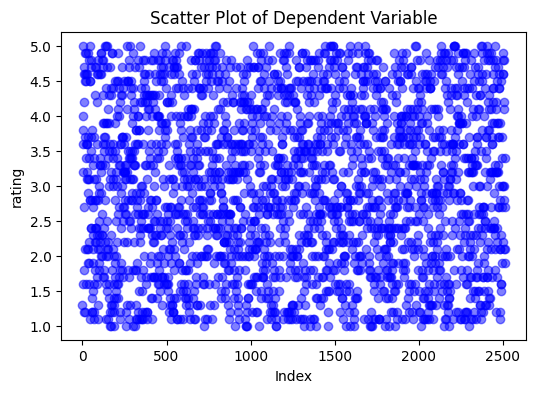

In [ ]:
# Scatter Plot of the Dependent Variable

plt.figure(figsize=(6,4))
plt.scatter(range(len(df)), df[dependent_var], color='blue', alpha=0.5)
plt.title("Scatter Plot of Dependent Variable")
plt.xlabel("Index")
plt.ylabel(dependent_var)
plt.show()


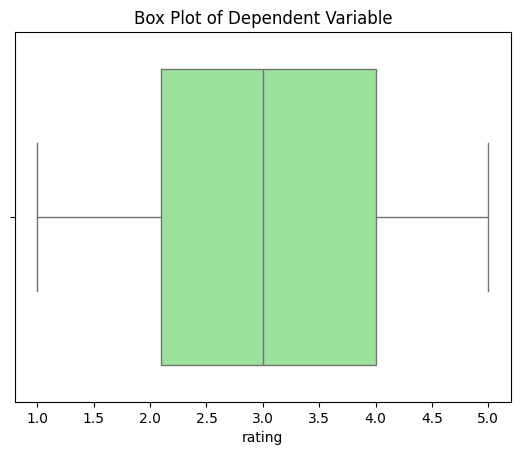

In [ ]:
# Box Plot of the Dependent Variable

sns.boxplot(x=df[dependent_var], color='lightgreen')
plt.title("Box Plot of Dependent Variable")
plt.show()

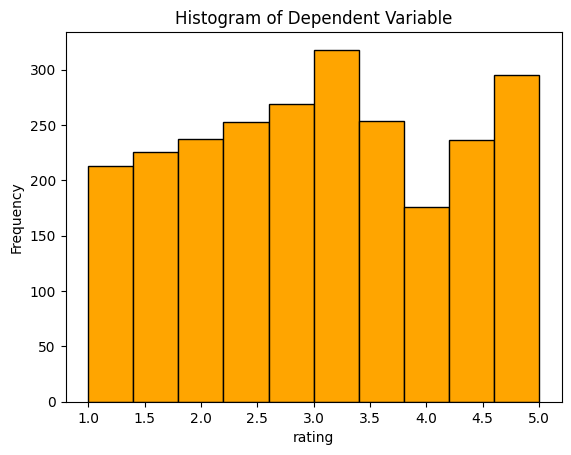

In [ ]:
# Histogram of Dependent Variable

plt.hist(df[dependent_var], bins=10, color='orange', edgecolor='black')
plt.title("Histogram of Dependent Variable")
plt.xlabel(dependent_var)
plt.ylabel("Frequency")
plt.show()

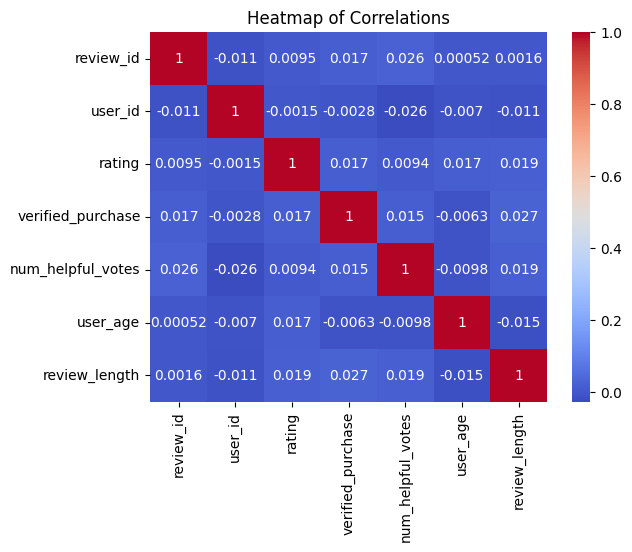

In [ ]:
# Heatmap of Correlations

corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Heatmap of Correlations")
plt.show()

In [ ]:
# HYPOTHESIS TESTING: CORRELATION

# Example independent variable: 'review_length'
independent_var = 'review_length'

print("\n===== Correlation Tests =====")

# Ensure 'rating' is numeric in the main DataFrame
if "rating" in df.columns:
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
else:
    print("Warning: 'rating' column not found. Skipping correlation test.")
    # Consider what to do if 'rating' is genuinely missing
    raise KeyError("'rating' column not found in DataFrame.")

# Ensure 'review_length' exists in the main DataFrame
if independent_var not in df.columns:
    text_col = None
    for c in ["review", "review_text", "comment", "text", "content", "body", "reviewBody"]:
        if c in df.columns:
            text_col = c
            break
    if text_col is not None:
        df[independent_var] = df[text_col].astype(str).str.len()
    else:
        print(f"Warning: '{independent_var}' or a suitable text column not found. Cannot perform correlation.")
        # Early exit if a critical column is missing
        raise KeyError(f"'{independent_var}' or a suitable text column not found in DataFrame.")


# Make sure both columns are numeric and have no NaN values
# Now both 'rating' and 'review_length' should be available in df
clean_df = df[[dependent_var, independent_var]].dropna().copy()
clean_df = clean_df.apply(pd.to_numeric, errors='coerce').dropna() # Ensure numeric again after filling

if not clean_df.empty:
    # Pearson Correlation
    pearson_corr, p_pearson = stats.pearsonr(clean_df[dependent_var], clean_df[independent_var])
    print(f"Pearson correlation: {pearson_corr:.3f} | P-value: {p_pearson:.5f}")

    # Spearman Correlation
    spearman_corr, p_spearman = stats.spearmanr(clean_df[dependent_var], clean_df[independent_var])
    print(f"Spearman correlation: {spearman_corr:.3f} | P-value: {p_spearman:.5f}")
else:
    print("Not enough clean data to perform correlation analysis.")



===== Correlation Tests =====
Pearson correlation: 0.019 | P-value: 0.35216
Spearman correlation: 0.008 | P-value: 0.68595


In [ ]:
# ONE-SAMPLE T-TEST (Sample vs Population Mean)

pop_mean = df[dependent_var].mean()

# Filter out NaN values from sample_random[dependent_var] before passing to ttest_1samp
sample_data_for_ttest = sample_random[dependent_var].dropna()

# Check if there's enough data after dropping NaNs
if len(sample_data_for_ttest) > 1:
    t_stat, p_val = stats.ttest_1samp(sample_data_for_ttest, pop_mean)

    print("===== One-Sample t-Test =====")
    print(f"T-Statistic: {t_stat:.3f} | P-Value: {p_val:.5f}")

    if p_val < 0.05:
        print(" The sample is significantly different from the population mean.")
    else:
        print(" The sample represents the population (no significant difference).")
else:
    print("===== One-Sample t-Test =====")
    print("Not enough data in the sample to perform one-sample t-test after dropping NaN values.")

===== One-Sample t-Test =====
T-Statistic: -1.350 | P-Value: 0.17916
 The sample represents the population (no significant difference).


In [ ]:
# REPORT SUMMARY

report = pd.DataFrame({
    "Statistic": desc_random.index,
    "Random_Sample": desc_random.values,
    "Systematic_Sample": desc_systematic.values
})

print("===== Final Descriptive Statistics Report =====")
print(report)
report.to_csv("Descriptive_Report.csv", index=False)
print("nReport saved as Descriptive_Report.csv")

===== Final Descriptive Statistics Report =====
   Statistic  Random_Sample  Systematic_Sample
0      count     148.000000         147.000000
1       mean       2.889865           2.937415
2     median       2.800000           3.000000
3       mode       3.300000           1.800000
4   variance       1.397652           1.159892
5    std_dev       1.182223           1.076983
6        min       1.000000           1.000000
7        max       5.000000           5.000000
8         Q1       1.975000           1.950000
9         Q3       4.000000           3.800000
10       IQR       2.025000           1.850000
nReport saved as Descriptive_Report.csv


In [ ]:
# simple regression
# Choose dependent & independent variable
dependent_var = "rating"          # Y
simple_feature = "review_length"  # X for simple regression

# Drop missing values
df_simple = df[[simple_feature, dependent_var]].dropna()

X = df_simple[[simple_feature]]
y = df_simple[dependent_var]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build model
simple_model = LinearRegression()
simple_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = simple_model.predict(X_test)

print("=== SIMPLE LINEAR REGRESSION ===")
print("Intercept:", simple_model.intercept_)
print("Coefficient:", simple_model.coef_[0])
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))





=== SIMPLE LINEAR REGRESSION ===
Intercept: 2.983425812192835
Coefficient: 0.0005441869173149062
R2 Score: 0.00041553305290042974
MSE: 1.3259660472736883


In [ ]:

# MULTIPLE LINEAR REGRESSION


numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
feature_cols = [c for c in numeric_cols if c != dependent_var]

df_multi = df[feature_cols + [dependent_var]].dropna()

X_multi = df_multi[feature_cols]
y_multi = df_multi[dependent_var]

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42
)

multi_model = LinearRegression()
multi_model.fit(X_train_m, y_train_m)

y_pred_m = multi_model.predict(X_test_m)

print("\n=== MULTIPLE LINEAR REGRESSION ===")
print("R2 Score:", r2_score(y_test_m, y_pred_m))
print("MSE:", mean_squared_error(y_test_m, y_pred_m))
print("Coefficients:", multi_model.coef_)






=== MULTIPLE LINEAR REGRESSION ===
R2 Score: -0.0024687674448040653
MSE: 1.329792121664151
Coefficients: [ 3.99991418e-05 -1.52804530e-09  1.22265068e-05  1.04434286e-03
  5.52279626e-04]


In [ ]:


# CLASSIFICATION MODELS
# Logistic, KNN, Naive-Bayes, Decision Tree


# Convert rating into class (1 = good, 0 = bad)
df_class = df_multi.copy()
df_class["label"] = (df_class[dependent_var] >= 4).astype(int)

X_cls = df_class[feature_cols]
y_cls = df_class["label"]

# Scale features (important)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cls)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_scaled, y_cls, test_size=0.2, random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

best_model = None
highest_accuracy = 0
best_name = ""

print("\n=== CLASSIFICATION MODELS ===")
for name, model in models.items():
    model.fit(X_train_c, y_train_c)
    y_pred_c = model.predict(X_test_c)

    acc = accuracy_score(y_test_c, y_pred_c)
    cm = confusion_matrix(y_test_c, y_pred_c)

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)

    if acc > highest_accuracy:
        highest_accuracy = acc
        best_model = model
        best_name = name

print("\nBest Classifier:", best_name)
print("Best Accuracy:", highest_accuracy)


=== CLASSIFICATION MODELS ===

Logistic Regression
Accuracy: 0.7318548387096774
Confusion Matrix:
 [[363   0]
 [133   0]]

KNN
Accuracy: 0.6895161290322581
Confusion Matrix:
 [[330  33]
 [121  12]]

Naive Bayes
Accuracy: 0.7298387096774194
Confusion Matrix:
 [[359   4]
 [130   3]]

Decision Tree
Accuracy: 0.5987903225806451
Confusion Matrix:
 [[263 100]
 [ 99  34]]

Best Classifier: Logistic Regression
Best Accuracy: 0.7318548387096774


In [ ]:
cluster_features = ["rating", "review_length"]
df_cluster = df[cluster_features].dropna().copy()

X_cluster = df_cluster.values

# Scaling
scaler_clust = StandardScaler()
X_cluster_scaled = scaler_clust.fit_transform(X_cluster)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_cluster_scaled)
df_cluster["kmeans_cluster"] = kmeans_labels

# Hierarchical (Agglomerative / "Horizontal")
hier = AgglomerativeClustering(n_clusters=3, linkage="ward")
hier_labels = hier.fit_predict(X_cluster_scaled)
df_cluster["hier_cluster"] = hier_labels

print("\n=== CLUSTERING RESULT (HEAD) ===")
print(df_cluster.head())


=== CLUSTERING RESULT (HEAD) ===
   rating  review_length  kmeans_cluster  hier_cluster
0     1.3             86               0             0
1     1.6             53               0             2
2     3.6             58               1             1
3     3.8             51               1             1
4     3.2             52               1             1


In [ ]:

# PREDICT USING BEST MODEL


best_predictions = best_model.predict(X_test_c)

print("\n=== BEST MODEL PREDICTIONS ===")
print(best_predictions[:20])


results_table = pd.DataFrame({
    "true_label": y_test_c.values,
    "predicted_label": best_predictions
})
print("\nSample of prediction table:")
print(results_table.head())


print("\n========= STRATEGY TO IMPROVE SYSTEM ========")
print("""
Simple strategy:

- If one cluster has LOW rating and LONG review_length:
  → These users are not happy and write long complaints.
  → Strategy: read their reviews, fix bugs, improve features they complain about.

- If one cluster has HIGH rating and SHORT review_length:
  → These users are happy and satisfied.
  → Strategy: keep same good service, maybe ask them to give app store reviews.

- If one cluster has MEDIUM rating:
  → These users are okay, but not very happy.
  → Strategy: improve performance, usability, or give small offers/promotions.

By using these clusters, we can treat each group differently and
improve the overall system quality and user satisfaction.
""")


=== BEST MODEL PREDICTIONS ===
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample of prediction table:
   true_label  predicted_label
0           0                0
1           0                0
2           0                0
3           0                0
4           0                0

========= STRATEGY TO IMPROVE SYSTEM ========

Simple strategy:

- If one cluster has LOW rating and LONG review_length:
  → These users are not happy and write long complaints.
  → Strategy: read their reviews, fix bugs, improve features they complain about.

- If one cluster has HIGH rating and SHORT review_length:
  → These users are happy and satisfied.
  → Strategy: keep same good service, maybe ask them to give app store reviews.

- If one cluster has MEDIUM rating:
  → These users are okay, but not very happy.
  → Strategy: improve performance, usability, or give small offers/promotions.

By using these clusters, we can treat each group differently and
improve the overall system quality and use